# Тестирование полученной модели AdaIN

# Содержание
## 1. [Определение модели](#section2)
- ### [Энкодер](#section2.1)
- ### [AdaIN-блок](#section2.2)
- ### [Декодер](#section2.3)
- ### [Итоговый класс модели переноса стиля](#section2.4)
## 2. [Загрузка тестовых данных](#section2)
## 3. [Функции загрузки и тестирования модели](#section3)
## 4. [Тестирование](#section4)

### Импорты

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import vgg19
import PIL
from PIL import Image

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## <center><a id="section2"></a>1. Реализация архитектуры </center>
### <a id="section2.1">2.1. Энкодер</a>

In [4]:
class Encoder(nn.Module):
    def __init__(self, base_cnn: nn.Sequential):
        super(Encoder, self).__init__()
        self.encoder = base_cnn

    def forward(self, inp, return_all_outputs=False):
        outp1 = self.encoder[:2](inp) # relu_1_1
        outp2 = self.encoder[2:7](outp1) # relu_2_1
        outp3 = self.encoder[7:12](outp2) # relu_3_1
        outp4 = self.encoder[12:21](outp3) # relu_4_1

        # для подсчёта потери стиля
        if return_all_outputs:
            return outp1, outp2, outp3, outp4
            
        return outp4    

### <a id="section2.2">2.2. AdaIN-блок</a>

In [5]:
class MeanStdCalculator(nn.Module):
    """
    Модуль подсчёта среднего значения и стандартного отклонения по каждому каналу.
    Пригодится в блоке AdaIN, а также при вычислении потери стиля.
    """
    def __init__(self):
        super(MeanStdCalculator, self).__init__()

    def forward(self, feature_maps: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        batch_size = feature_maps.size()[0]
        channels = feature_maps.size()[1]
        
        mean = feature_maps.reshape(batch_size, channels, -1).mean(dim=2).reshape(batch_size, channels, 1, 1)
        std = feature_maps.reshape(batch_size, channels, -1).std(dim=2).reshape(batch_size, channels, 1, 1)

        return mean, std
        

class AdaIN(nn.Module):
    """
    Модуль адаптивной инстанс нормализации.
    Преобразует карты признаков контента согласно распределения карт признаков для стиля.
    """
    def __init__(self):
        super(AdaIN, self).__init__()
        self.mean_std_calc = MeanStdCalculator()
        
    def forward(self, content_features, style_features) -> torch.Tensor:
        content_mean, content_std = self.mean_std_calc(content_features)
        content_std = content_std + 1e-8
        style_mean, style_std = self.mean_std_calc(style_features)
        style_std = style_std + 1e-8

        norm_content = (content_features - content_mean) / content_std
        adapt_content = norm_content * style_std + style_mean

        return adapt_content

### <a id="section2.3">2.3. Декодер</a>

In [6]:
class Decoder(nn.Module):
    """
    Декодер должен хорошо научиться восстанавливать изображения,
    для этого понадобится использовать бОльшее количество свёрток чем 3.
    """
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, inp):
        return self.block3(self.block2(self.block1(inp)))

### <a id="section2.4">2.4. Итоговый класс модели переноса стиля</a>

In [7]:
class AdainStyleTransferModel(nn.Module):
    def __init__(self, base_cnn: nn.Sequential):
        super(AdainStyleTransferModel, self).__init__()
        self.encoder = Encoder(base_cnn=base_cnn)
        self.adain = AdaIN()
        self.decoder = Decoder()
        self.mean_std_calc = MeanStdCalculator()

    
    def stylize(self, content: torch.Tensor, style: torch.Tensor, alpha: float = 1.0):
        """
        Функция стилизации, которая будет применяться при инференсе.
        * alpha - число [0, 1], степень переноса стиля
        """
        content_features = self.encoder(content, return_all_outputs=False) # карты признаков контента с последнего слоя энкодера 
        style_features = self.encoder(style, return_all_outputs=False) # карты признаков стиля с последнего слоя энкодера
        
        adain_features = self.adain(content_features, style_features) # модифицированные карты признаков контента (стилизованные)
        adain_features = alpha * adain_features + (1 - alpha) * content_features # контроль степени стилизации при помощи alpha
        
        outp = self.decoder(adain_features) # получение стилизованного изображения исходного (512х512) размера
        
        return outp


    def __content_loss(self, result_enc_outp, adain_features):
        """
        * result_enc_outp - выход энкодера для D(adain_content), где D - декодер
        * adain_content - выход блока AdaIN, преобразованные фичи изначального контент-изображения
        """
        return torch.nn.MSELoss(reduction='mean')(result_enc_outp, adain_features)

    
    def __style_loss(self, result_enc_outputs, style_enc_outputs):
        """
        * result_enc_outputs - выходы всех рассмотренных выше слоев энкодера для полученной декодером стилизации
        * style_enc_outputs - выходы всех рассмотренных выше слоев энкодера для изображения стиля
        """
        style_loss_ = 0.0
        for result_outp, style_outp in zip(result_enc_outputs, style_enc_outputs):
            result_outp_mean, result_outp_std = self.mean_std_calc(result_outp)
            style_outp_mean, style_outp_std = self.mean_std_calc(style_outp)

            style_loss_ += torch.nn.MSELoss(reduction='mean')(result_outp_mean, style_outp_mean) + torch.nn.MSELoss(reduction='mean')(result_outp_std, style_outp_std)
            
        return style_loss_
        

    def forward(self, content_images, style_images, alpha=1.0, style_weight=10):
        content_features = self.encoder(content_images)
        style_features = self.encoder(style_images)
        
        adain_features = self.adain(content_features, style_features)
        adain_features = alpha * adain_features + (1 - alpha) * content_features
        
        result = self.decoder(adain_features)                 

        result_features = self.encoder(result, return_all_outputs=False)    
        result_all_features = self.encoder(result, return_all_outputs=True)   
        style_all_features = self.encoder(style_images, return_all_outputs=True)   

        
        content_loss = self.__content_loss(result_features, adain_features)     
        style_loss = self.__style_loss(result_all_features, style_all_features)  

        loss = content_loss + style_weight * style_loss
        
        return loss

## <center><a id="section3"></a>3. Тестовые данные </center>

In [8]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [9]:
import os
from PIL import Image

IMSIZE = (512, 512)

VGG19_NORMALIZATION_MEAN = torch.tensor([0.485, 0.456, 0.406])
VGG19_NORMALIZATION_STD = torch.tensor([0.229, 0.224, 0.225])


# Тестовые данные
test_contents_directory = "../test-data/contents/"
test_styles_directory = "../test-data/styles/"

test_content_names = os.listdir(test_contents_directory) 
test_style_names = os.listdir(test_styles_directory)

test_content_paths = [test_contents_directory + i for i in test_content_names]
test_style_paths = [test_styles_directory + i for i in test_style_names]

In [10]:
class ImagesTestDataset(Dataset):
    """
    Загрузка и предобработка изображений для тестирования.
    Нужно провести следующие преобразования над изображениями:
    * resize -> (512, 512)
    * преобразование к тензору
    * нормализация согласно значениям для VGG-19
    """

    def __init__(self, files: list[str]):
        super(ImagesTestDataset, self).__init__()
        
        self.files = sorted(files)
        self.len_ = len(self.files)


    def __len__(self):
        return self.len_


    def load_sample(self, file):
        with Image.open(file) as image:
            image.load()
            return image.resize(IMSIZE)


    def __getitem__(self, index):
        rgb_found = False
        while not(rgb_found):
            x = self.load_sample(self.files[index])
            x = transforms.ToTensor()(x)[:3] # учитываем, что некоторые картинки могут иметь 4 канала, из-за чего нормализация может сломаться
            if len(x) == 3:
                x = transforms.Normalize(VGG19_NORMALIZATION_MEAN, VGG19_NORMALIZATION_STD)(x)
                rgb_found = True
                return x
            index = index + 1

In [11]:
def denorm_images(images, device):
    """
    Денормализация изображений на выходе.
    Args:
        * images (torch.Tensor) : батч нормализованных картинок
    """
    means = torch.tensor(VGG19_NORMALIZATION_MEAN).reshape(1, 3, 1, 1).to(device) 
    stds = torch.tensor(VGG19_NORMALIZATION_STD).reshape(1, 3, 1, 1).to(device)

    return images * stds + means  

In [12]:
test_content_dataset = ImagesTestDataset(test_content_paths)
test_style_dataset = ImagesTestDataset(test_style_paths)

In [13]:
from torch.utils.data import DataLoader

test_content_dataloader = DataLoader(dataset=test_content_dataset, batch_size=1, shuffle=False)
test_style_dataloader = DataLoader(dataset=test_style_dataset, batch_size=1, shuffle=False)

____________________________

## <center><a id="section4"></a>4. Функции загрузки и тестирования модели. </center>

In [14]:
def load_model(path: str, device):
    base_cnn = vgg19(True).features[:21]

    for param in base_cnn.parameters():
        param.requires_grad = False

    model = AdainStyleTransferModel(base_cnn).to(device)

    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])

    return model

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [16]:
def test_model(model, content_loader, style_loader):
    model.eval()
    
    style_it = iter(style_loader)
    
    time_sum = 0.0
    i = 0
    
    with torch.no_grad():
        for content in content_loader:
            i += 1
            
            content = content.to(device)
            style = next(style_it).to(device)

            t_start = time.time()
            outp = model.stylize(content, style, alpha=1.0)
            t_end = time.time()
            time_sum += t_end - t_start

            outp = denorm_images(outp, device)[0]
            outp.clamp_(0, 1)
            
            fig, axes = plt.subplots(1, 3, figsize=(10, 5))
            axes[0].set_title("Test content")
            axes[1].set_title("Test style")
            axes[2].set_title("Test result")
            axes[0].imshow(transforms.ToPILImage()(denorm_images(content, device)[0]))
            axes[1].imshow(transforms.ToPILImage()(denorm_images(style, device)[0]))
            axes[2].imshow(transforms.ToPILImage()(outp))
            plt.show()
    print(f"Avg time = {time_sum / i}")

______________________________________

## <center><a id="section5"></a>5. Тестирование.</center>

In [17]:
model7 = load_model('./models/adain_style_model.pt', device)
model7 = model7.to(device)

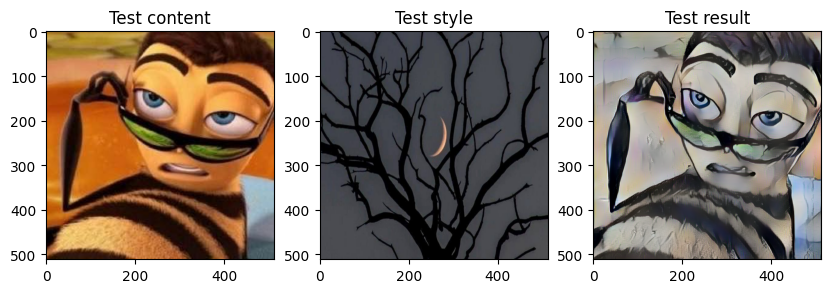

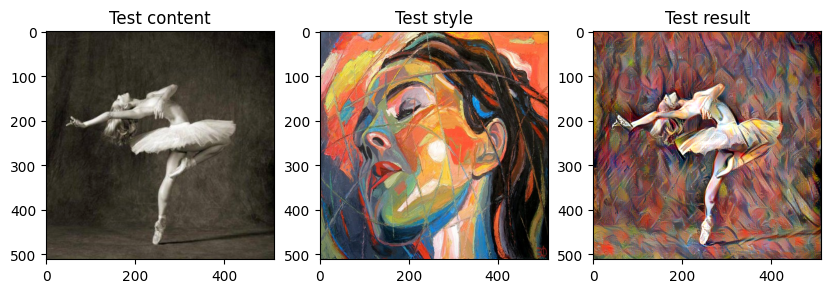

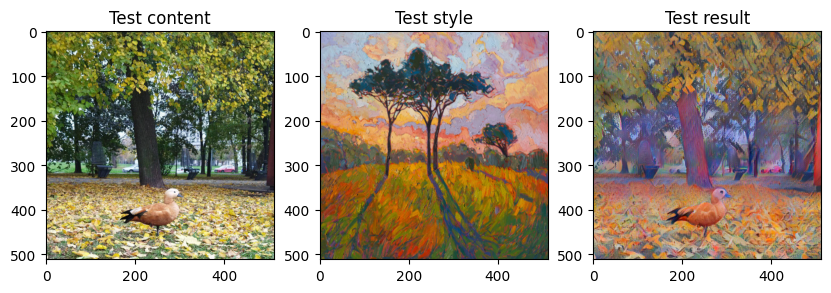

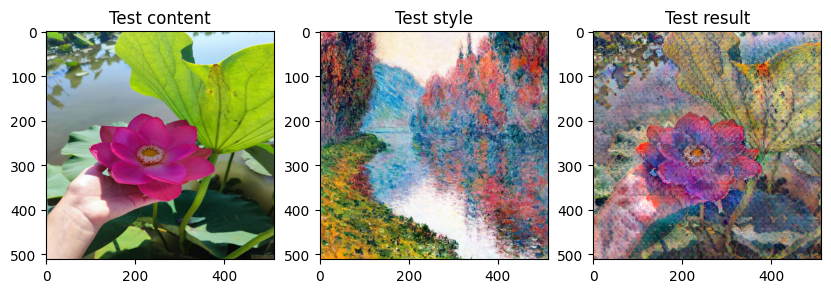

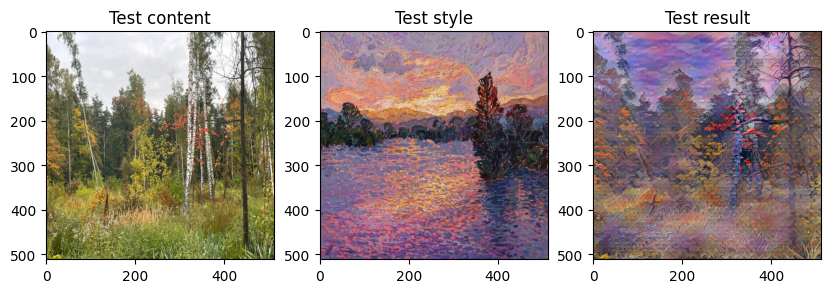

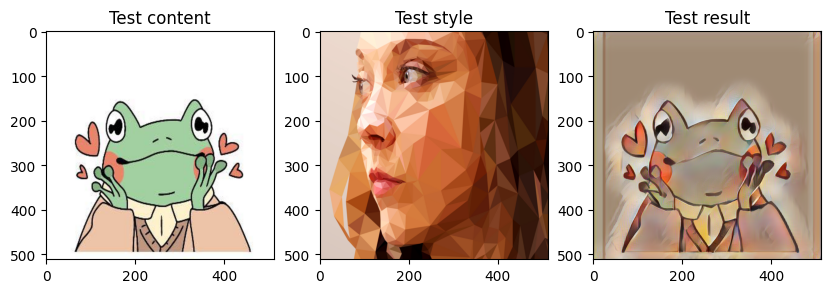

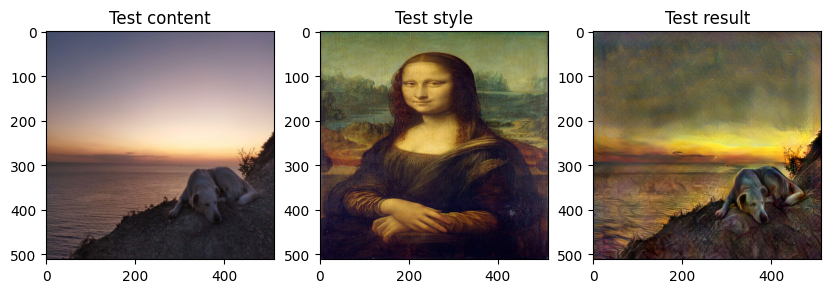

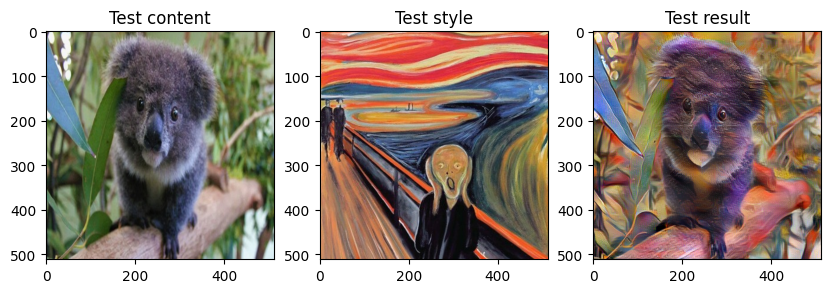

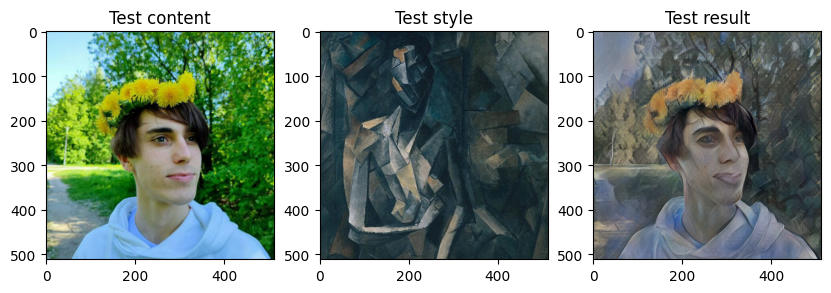

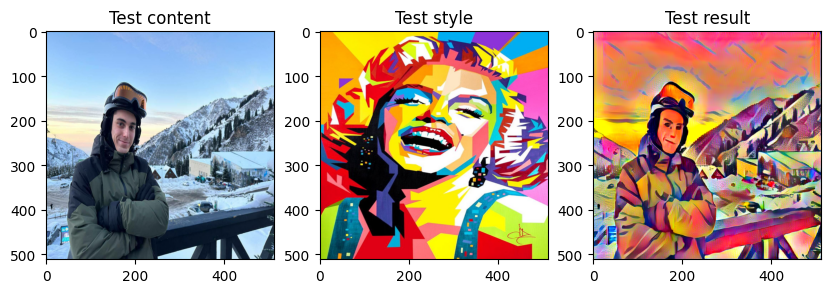

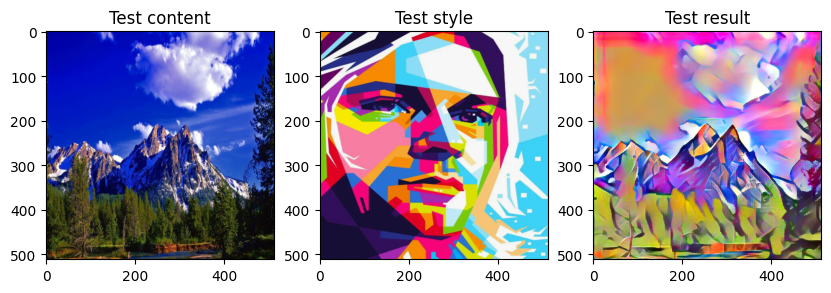

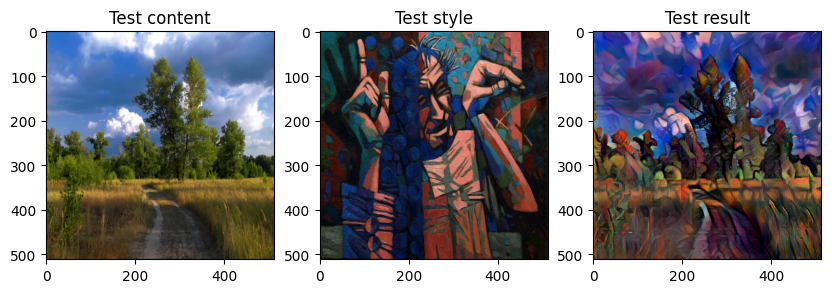

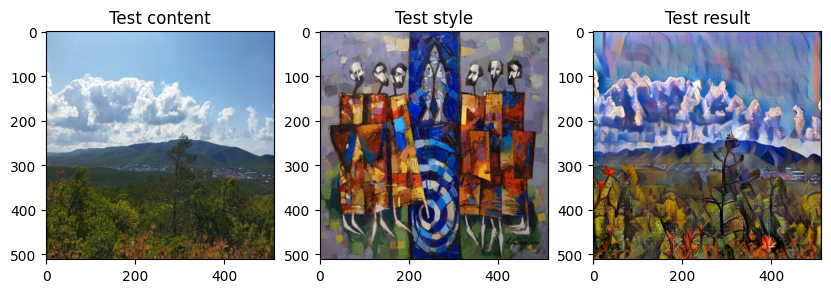

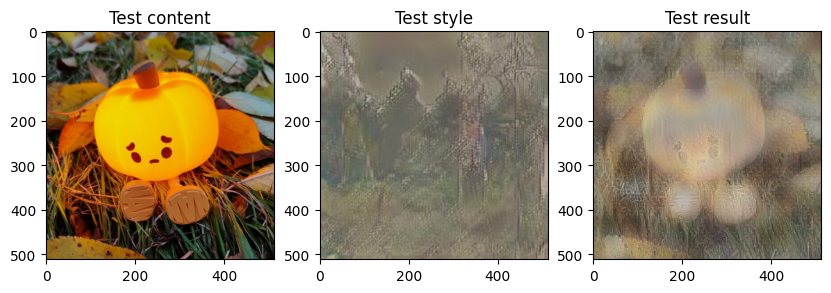

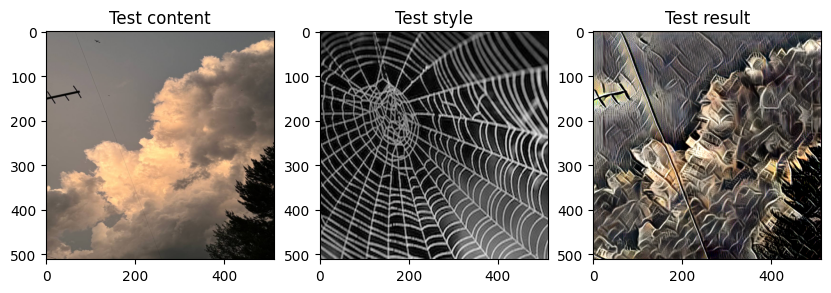

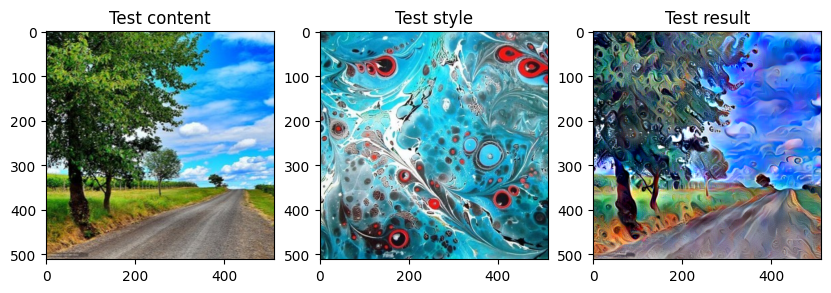

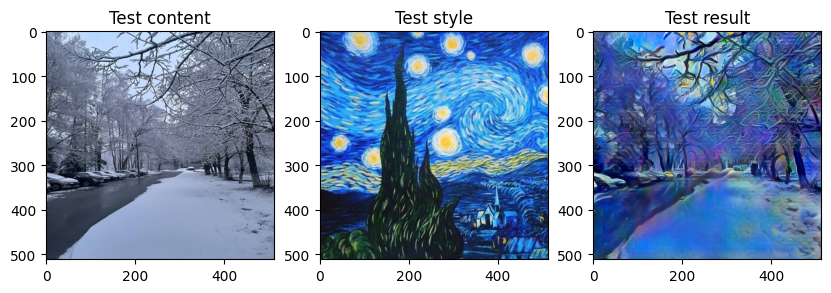

Avg time = 1.8696514999165255


In [18]:
test_model(model7, test_content_dataloader, test_style_dataloader)